In [82]:
%load_ext Cython
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython


In [343]:
%%cython
cimport cython

import numpy as np
cimport numpy as np
import networkx as nx
from scipy.linalg import toeplitz

cpdef tuple initialize_lattice(int L, int states):
    '''Inititalizes a lattice graph including states and an adjency matrix'''
    # init graph
    G = nx.grid_2d_graph(L,L)
    cdef int length = len(G.nodes())
    
    # assign random state to each node and put in array
    cdef np.ndarray G2 = np.random.randint(low=0, high=states, size=length)
    
    # adjency matrix
    cdef np.ndarray A = nx.adjacency_matrix(G).todense()
    
    return G2, A

cdef np.ndarray neighbors(A, node):
    '''Return an numpy array containing the neighbors of a node'''
    cdef np.ndarray nb = np.where(A[node]==1)[1]
    return nb

cdef np.ndarray init_J(int states):
    '''Interaction matrix initialization'''
    assert states > 1, 'number of states needs to be more than 1'
    cdef np.ndarray J
    if states == 2: # A <-> A , B <-> B
        J = np.array([[1, 0],\
                      [0, 1]])
        
    else:
        first_row = np.zeros(states)
        first_row[1] = 1
        first_col = np.zeros(states)
        first_col[1] = 1

        J = toeplitz(first_col, first_row)
    return J

cdef float hamiltonian(G, int node, np.ndarray nb, np.ndarray J):
    '''
    Hamiltonian function: Calculate the energy for each bond of a single node
    , return the sum of these energies

    H: Hamiltonian
    cur_node: investigated current node
    cur_nb: investigated current neighbor
    kronecker (not used): 1 if two nodes are in same state
    '''
    cdef float H = 0
    cdef int cur_node = G[node]
    cdef int cur_nb
    cdef int kronecker
    
    # loop through all neighbors
    for i in range(len(nb)):
        cur_nb = G[nb[i]]
        kronecker = 0
        
        # check if states are the same
        if cur_node == cur_nb:
            kronecker = 1
#         H += -1 * (1 - kronecker) #J[cur_node, cur_nb]) # * V[]
#         H -= 1 * (1 - J[cur_node, cur_nb]) # * V[]
        H -= J[cur_node, cur_nb]
    return H
    
cdef metropolis(G, A, J, int states, float beta, int time, float system_hamiltonian):
    '''
    Performs all metropolis algorithm steps.
    
    Difference in energy is - (H2 (new state) - H1 (old state)) .
    System hamiltonian and magnetization is changed.
    TODO: Check system magnetization 
    '''
    cdef int rand_node
    cdef int spin
    cdef float dE = 0
    cdef int rand_state
    cdef float p
    cdef float H1 
    cdef float H2
    cdef list sh = []
    cdef list fm = []

    fm.append(G.mean())
    cdef list history_arr = []
    
    for t in range(time):    
        for i in range(len(G)):
            # pick random node
            rand_node = np.random.randint(len(G)-1)
            spin = G[rand_node]
            
            rand_state = np.random.randint(states)
            while rand_state == spin:
                rand_state = np.random.randint(states)
            
            # calculate hamiltonian for current configuration
            nb = neighbors(A, rand_node)
            H1 = hamiltonian(G, rand_node, nb, J)
            
            # calculate hamiltonian for new configuration
            G_copy = G.copy()
            G_copy[rand_node] = rand_state
            H2 = hamiltonian(G_copy, rand_node, nb, J)

            # calculate energy difference
            dE = (H2 - H1)
                        
            # energy may always be decreased
            if dE <= 0:
                p = 1   
                
            # probability proportional to Boltzmann distribution.
            else: 
                p = np.exp(-beta*dE)
                
            # energy is increased with probability
            if np.random.random() <= p:
                G[rand_node] = rand_state
                system_hamiltonian += dE
                
            # change configuration back to the original
            else: 
                G[rand_node] = spin
    
            sh.append(system_hamiltonian)
            fm.append(G.mean())
            history_arr.append(G.copy())

    return G, sh, history_arr

cdef float full_hamiltonian(G, A, J):
    '''
    Returns the energy state of the system.
    '''
    cdef float system_hamiltonian = 0 
    for i in range(len(G)):
        nb = neighbors(A, i)
        system_hamiltonian += hamiltonian(G, G[i], nb, J)
    return 0.5 * system_hamiltonian

cdef float full_satisfaction(G,A,J):
    'returns average satisfaction of the nodes'
    cdef float system_satisfaction = 0
    for i in range(len(G)):
        nb = neighbors(A, i)
        system_satisfaction += satisfaction(G, G[i], nb, J)
    return system_satisfaction * 0.5

cdef float satisfaction(G, int node, np.ndarray nb, np.ndarray J):
    cdef int cur_node = G[node]
    cdef int cur_nb
    cdef int s = 0
    
    # loop through all neighbors
    for i in range(len(nb)):
        cur_nb = G[nb[i]]
        if J[cur_node, cur_nb] == 0:
            s -=0
        else: 
            s += 1  
    return s
   
### Simulation functions
def simulate(T, states):
    lattice_size = 10
    G, A = initialize_lattice(lattice_size, states)
    G_init = G.copy()
    J = init_J(states)    
    sh = full_hamiltonian(G,A,J)        
    beta = 1 / T
    timesteps = 100
    M, system_hamiltonian, fm = metropolis(G, A, J, states, beta, timesteps, sh)
    return G_init, J, system_hamiltonian, A, fm
    
def sep_ham(fm, A, J):
    l = []
    for step in range(len(fm)):
        l.append(full_hamiltonian(fm[step], A, J))
    return l
    
def sep_sat(fm, A, J):
    l= []
    for step in range(len(fm)):
        l.append(full_satisfaction(fm[step], A, J))
    return l

In [344]:
# G_init, J, system_hamiltonian, A, fm = simulate(0.01, 2)
# print(sep_sat(fm, A, J),"\n", fm[-1].reshape(3,3))

In [345]:
def put_in_dataframe(fm, system_hamiltonian, A, J):
    '''
    Save data in convenient manner using pandas dataframe for each run, which is stored in a dictionary.
    '''
    df = pd.DataFrame(data=fm)
    # put energy value of timestep in last column
#     df.loc[:, fm[0].shape[0]+1] = sep_ham(fm, A, J)
    df.loc[:, fm[0].shape[0]+2] = system_hamiltonian
    df.loc[:, fm[0].shape[0]+3] = sep_sat(fm, A, J)
    return df

In [350]:
temperatures = [0.01, 0.5, 1, 1.5, 2.0, 2.5, 5]# np.arange(0.01)
states = [2, 3, 4, 5, 6, 7, 8, 9, 10]
samples = np.arange(0,5,1)
def perform_tests(temperatures, states, samples):
    '''
    Perform multiple simulations with different temperatures and states.
    Saves the system-hamiltonian per step of multiple runs.
    '''
    runs = {}
    for state in states:
        for temp in temperatures:
            print(temp)
            for run in samples:
                G_init, J, system_hamiltonian, A, fm = simulate(temp, state)
                df = put_in_dataframe(fm, system_hamiltonian, A, J)
                runs[f'run{state,temp,run}'] = df             
    return runs

runs = perform_tests(temperatures, states, samples)
    
# for key in runs.keys():
#     print(key)

0.01
0.5
1
1.5
2.0
2.5
5
0.01
0.5
1
1.5
2.0
2.5
5
0.01
0.5
1
1.5
2.0
2.5
5
0.01
0.5
1
1.5
2.0
2.5
5
0.01
0.5
1
1.5
2.0
2.5
5
0.01
0.5
1
1.5
2.0
2.5
5
0.01
0.5
1
1.5
2.0
2.5
5
0.01
0.5
1
1.5
2.0
2.5
5
0.01
0.5
1
1.5
2.0
2.5
5


In [362]:
# runs[f'run{2,0.1,0}']
import pickle
filename = 'experiment1'
outfile = open(filename,'wb')
pickle.dump(runs,outfile)
outfile.close()
# favorite_color = pickle.load( open( "save.p", "rb" ) )

# infile = open(filename,'rb')
# new_dict = pickle.load(infile)
# infile.close()

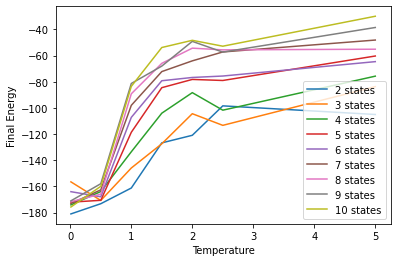

In [451]:
lattice_size = 10
timesteps = 100
i1 = lattice_size**2 + 1
i2 = lattice_size**2 * timesteps - 1

for state in states:
        l = []
        k = []
        for temp in temperatures:
            fh = 0
            sh = 0
            satisfaction = 0
            for run in samples:
#                 fh += runs[f'run{state,temp,run}'][i1][i2]
                sh += runs[f'run{state,temp,run}'][i1+1][i2]
                satisfaction += runs[f'run{state,temp,run}'][i1+2][i2]
            l.append(sh/len(samples))
            k.append(satisfaction/len(samples)/lattice_size**2)
        plt.plot(temperatures, l, label=f'{state} states')
#         plt.plot(temperatures, k, label=f'{state}ver2')

plt.ylabel('Final Energy')
plt.xlabel('Temperature')
plt.legend()

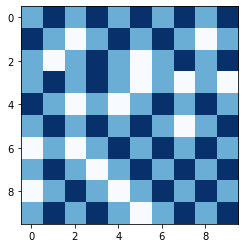

In [429]:
%matplotlib inline

import matplotlib.animation as animation
from matplotlib.animation import PillowWriter

fig = plt.figure()
ims = []
for i in range(i2):
    if i%100 == 0:
        im = plt.imshow(np.array(runs['run(3, 0.01, 0)'].loc[i,:99]).reshape(lattice_size, lattice_size), cmap='Blues', animated=True)
        ims.append([im])
    
ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True, repeat_delay=1000)

writer = PillowWriter(fps=10)
ani.save("demo2.gif", writer=writer)

plt.show()

0.01
0.5
1
1.5
2.0
2.5
5


Text(0, 0.5, 'hamiltonian energy')

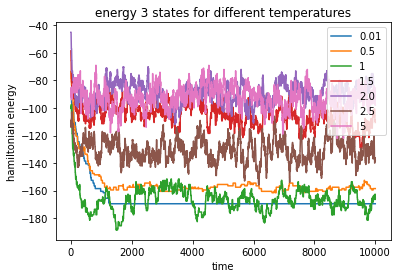

In [454]:
for temp in temperatures:
    print(f'{temp}')
    plt.plot(np.arange(0, i2+1, 1), runs[f'run(3, {temp}, 0)'][102], label=temp)

plt.legend()
plt.title('energy 3 states for different temperatures')
plt.xlabel('time')
plt.ylabel('hamiltonian energy')

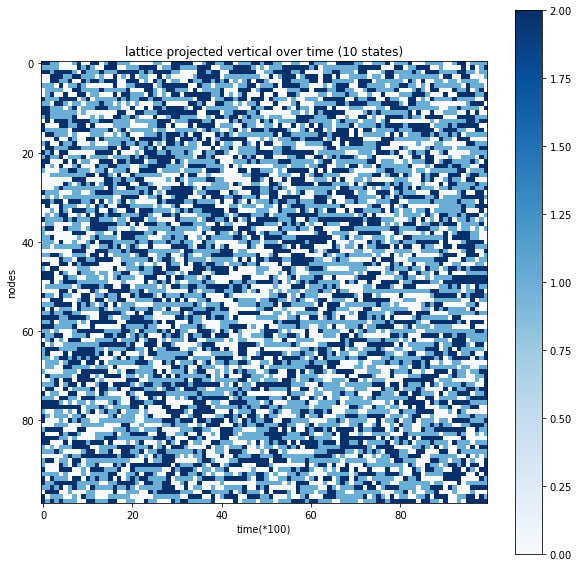

In [524]:
# np.array(runs['run(3, 0.01, 0)'].loc[:99])

plt.figure(figsize=(10,10))
plt.imshow(np.array(runs['run(3, 5, 0)'].iloc[::100, :99]).T, cmap='Blues')
plt.colorbar()
plt.title('lattice projected vertical over time (10 states)')
plt.ylabel('nodes')
plt.xlabel('time(*100)')
plt.show()

In [336]:
# G_init.reshape(12,12)

In [99]:
# M.reshape(12,12)

In [217]:
#plt.imshow(M.reshape(12,12))

In [94]:
temperatures = np.linspace(0.01, 5, 10) #[0.1, 1, 2, 4, 10]
# temperatures = np.logspace(0.01, 10, 10)
states = [2, 3, 4]
runs = np.arange(0, 10, 1)

info_runs = np.zeros((len(states)*len(temperatures), 2))
avg_runs = np.zeros((len(runs)*len(states)*len(temperatures), 14400))
vc_satisfaction = np.zeros((len(runs)*len(states)*len(temperatures), 144))


def perform_tests(temperatures, states):
    '''
    Perform multiple simulations with different temperatures and states.
    Saves the system-hamiltonian per step of multiple runs.
    '''
    i = 0
    j = 0
    for state in states:
        print(state)
        for temp in temperatures:
            info_runs[j] = state, temp 
            j += 1
            for run in runs:
                G_init, M, system_hamiltonian, J, fm = simulate(temp, state)    
                avg_runs[i] = system_hamiltonian
                vc_satisfaction[i] = M
                i += 1
    return info_runs, avg_runs

info_runs, avg_runs = perform_tests(temperatures, states)

2
3
4


In [46]:
avg = np.zeros((avg_runs.shape[1]))
std = np.zeros((avg_runs.shape[1]))
minm = np.zeros((avg_runs.shape[1]))
maxm = np.zeros((avg_runs.shape[1]))

i = 0
start = 0
stop = runs.shape[0]

list_of_avg_end = []
plot = True

for k in range(len(states)*len(temperatures)):
    for i in range(avg_runs.shape[1]):
        avg[i] = np.mean(avg_runs[start:stop, i])
        std[i] = np.std(avg_runs[start:stop, i])
        minm[i] = np.amin(avg_runs[start:stop, i])
        maxm[i] = np.amax(avg_runs[start:stop, i])

    x = np.arange(0, avg_runs.shape[1])
    y = avg
    list_of_avg_end.append([info_runs[k][0], info_runs[k][1], avg[-1]])
    
    if plot == True:
        plt.plot(x,y, 'k-')
        plt.fill_between(x, y+std, y-std)
        plt.xlabel('timestep')
        plt.ylabel('sum of bond energies')
        plt.title('Temperature = '+ str(info_runs[k][1]) +' States = '+ str(info_runs[k][0]))
        plt.savefig('/home/thomas/Thesis/code/Potts/experiments/Hamiltonian plot, T=' + str(info_runs[k][1]) + 'states='+ str(info_runs[k][0]) +'.png', dpi=100)
        plt.show()
    
    start = stop + 1
    stop = stop + runs.shape[0]

NameError: name 'avg_runs' is not defined

In [96]:
temp2 = []
last2 = []
temp3 = []
last3 = []
temp4 = []
last4 = []

for i in list_of_avg_end:
    if i[0] == 2:
        last2.append(i[2])
        temp2.append(i[1])
        
    if i[0] == 3:
        last3.append(i[2])
        temp3.append(i[1])
        
    if i[0] == 4:
        last4.append(i[2])
        temp4.append(i[1])

Text(0, 0.5, 'Sum of bond energies')

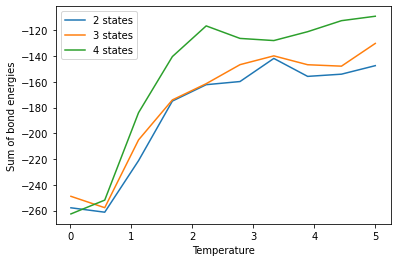

In [97]:
plt.plot(temp2, last2, label='2 states')
plt.plot(temp3, last3, label='3 states')
plt.plot(temp4, last4, label='4 states')
plt.legend()
plt.xlabel('Temperature')
plt.ylabel('Sum of bond energies')

In [98]:
# unused code for plotting
if plot == True:
    # save 3 figures
    fig, axs = plt.subplots(2)
    fig.suptitle('T={}, states={}'.format(temp, state))
    pos = axs[0].imshow(G_init.reshape(12, 12), cmap='Blues')
    fig.colorbar(pos)
    pos = axs[1].imshow(M.reshape(12,12), cmap='Blues')
    fig.colorbar(pos)
    plt.savefig('/home/thomas/Thesis/code/Potts/experiments/T=' + str(temp) + 'states='+ str(state) +'.png', dpi=100)
#             plt.show()

    fig, axs = plt.subplots(1)
    fig.suptitle('T={}, states={}'.format(temp, state))
    axs.plot(t, system_hamiltonian)
    plt.savefig('/home/thomas/Thesis/code/Potts/experiments/Hamiltonian plot, T=' + str(temp) + 'states='+ str(state) +'.png', dpi=100)
#             plt.show()

In [58]:
 # Save a dictionary into a pickle file.
import pickle
favorite_color = np.zeros((2,2))
pickle.dump( favorite_color, open( "save.p", "wb" ) )

In [59]:
# Load the dictionary back from the pickle file.
import pickle
favorite_color = pickle.load( open( "save.p", "rb" ) )
# favorite_color is now { "lion": "yellow", "kitty": "red" }


In [60]:
favorite_color

array([[0., 0.],
       [0., 0.]])